In [1]:
#imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers
import tensorflow.keras.metrics # import Precision, Recall,Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import classification_report

2023-03-13 00:00:48.186383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 00:00:48.336864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 00:00:48.336905: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 00:00:49.114882: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
path_to_dataset = os.path.join("..","..","data","food")
path_to_dataset = os.path.join("..","..","test_data","3_whole_bucket_no_aug")

path_to_dataset_local = os.path.join("..","test_data","0_local_500")
path_to_dataset = path_to_dataset_local

path_to_dataset_train = os.path.join(path_to_dataset, "train")
path_to_dataset_test = os.path.join(path_to_dataset,  "test")
path_to_dataset_val = os.path.join(path_to_dataset,   "val")

In [6]:
batch_size = 16 #None = 1 #16 #32
IMG_SIZE = 224
seed_train_validation = 69 # Must be same for train_ds and val_ds

In [7]:
new_way = True
label_mode = "int" 

def load_data_new_way():
    #path_to_dataset = os.path.join("..", "test_data", "3_test_from_bucket2")
    
#     path_to_dataset = os.path.join("..","..","data","food")
    
#     #path_to_dataset = os.path.join("..", "..", "test_data", "3_whole_bucket_no_aug")
    
#     path_to_dataset_train = os.path.join(path_to_dataset, "train")
#     path_to_dataset_test = os.path.join(path_to_dataset,  "test")
#     path_to_dataset_val = os.path.join(path_to_dataset,   "val")
    
    X_train = image_dataset_from_directory(
        path_to_dataset_train,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        shuffle=True
        )

    X_val = image_dataset_from_directory(
        path_to_dataset_val,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        shuffle=True
        )

    X_test = image_dataset_from_directory(
        path_to_dataset_test,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        shuffle=False
        )
    return X_train,X_val,X_test

X_train, X_val, X_test = load_data_new_way()

#print sample label

Found 11316 files belonging to 45 classes.


2023-03-13 00:02:28.489857: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 00:02:28.489906: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 00:02:28.489923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Louis-Laptop-Lenovo): /proc/driver/nvidia/version does not exist
2023-03-13 00:02:28.490211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1519 files belonging to 45 classes.
Found 1537 files belonging to 45 classes.


In [8]:
def get_target_dict():
    classes = X_test.class_names
    classes.sort()
    #classes.remove(".ipynb_checkpoints")
    target_dict_out = {}
    for index, veg in enumerate(classes):
        target_dict_out[index] = veg
    return target_dict_out
target_dict = get_target_dict()
target_dict;

test label: [ 0 28  9 24 44 33 36 19 19  2 41 36 19 19 14  3]
first test label: 0


Text(0.5, 1.0, 'apple')

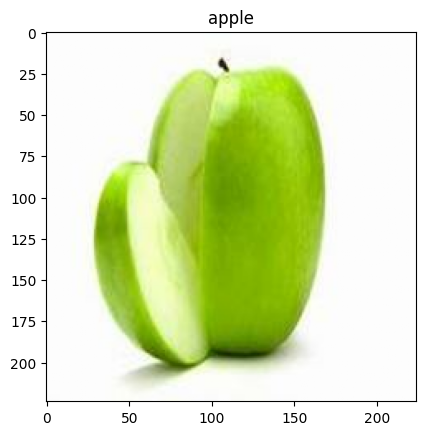

In [9]:
count = 0
test_image, test_label = None, None

for image, label in X_train:#.take(1):
    if count == 0 :
        test_image = image.numpy()
        test_label = label.numpy()
    count+=1
    if count > 0: break
    
#if you want to see an image
print("test label:", test_label)
print("first test label:", test_label[0])

plt.imshow(test_image[0]/255)
plt.title(target_dict[test_label[0]])

In [10]:
in_shape = test_image[0].shape
in_shape

num_classes = len(X_train.class_names)
print("num_classes: ", num_classes)
print("in_shape: "   , in_shape)

num_classes:  45
in_shape:  (224, 224, 3)


In [11]:
def show_layer_result(layer, title="", rescale=True):
    
    if rescale:
        rescaled_img = resize_and_rescale(test_image[0])
        result = layer(rescaled_img)
    else:
        result = rescale_layer(test_image[0])
        
    _ = plt.imshow(result)
    plt.title(title)
    print("Min and max pixel values:", result.numpy().min(), result.numpy().max())
    return None

Min and max pixel values: 0.0 1.0


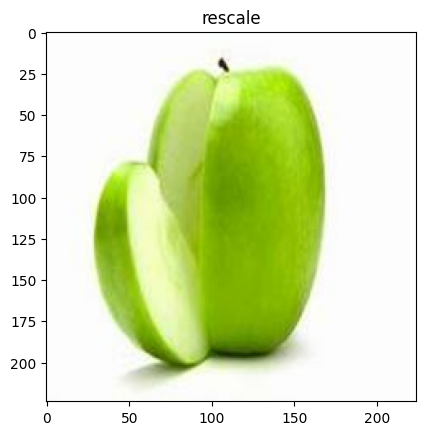

In [12]:
#resize and rescale layer
def get_rescale_layer():
    rescale_layer = tf.keras.Sequential([
        #image = tf.cast(image, tf.float32)
      layers.Resizing(IMG_SIZE, IMG_SIZE),
      layers.Rescaling(1./255)
    ])
    
    return rescale_layer
    
rescale_layer = get_rescale_layer()
show_layer_result(rescale_layer, "rescale", rescale=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


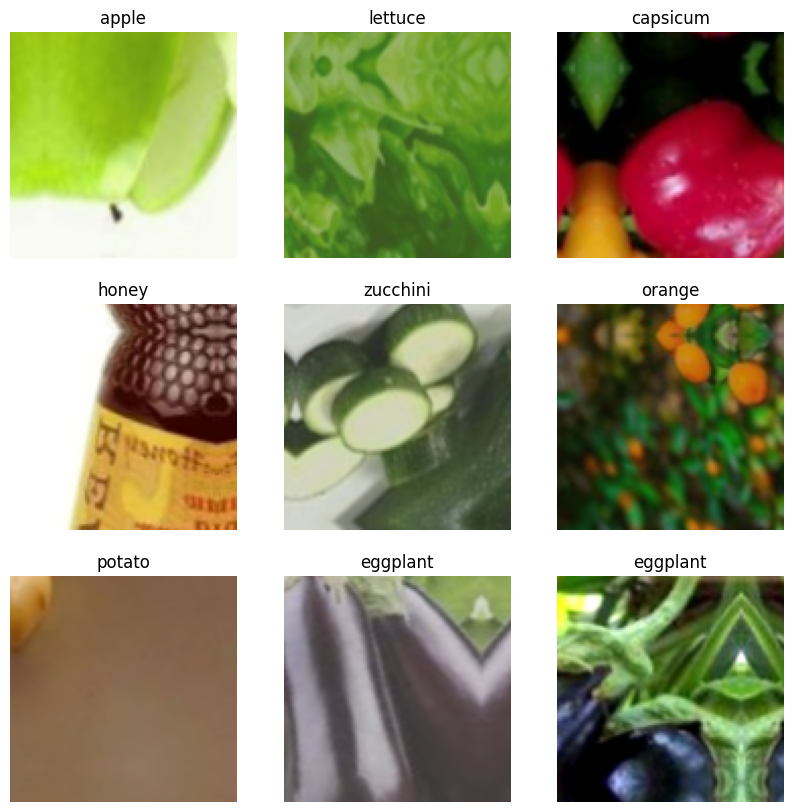

In [13]:
def get_augment_layer():

    rotation    = 0.1 # 0.25 would be 90 degrees as 2pi/4 = pi/2 = 90
    translation = 0.2 #width and height factor
    contrast    = 0.6 #apparently 1-this is applied
    zoom        = 0.1
    crop_size   = 112 #224/2?

    fill_mode = "reflect" #"constant"    #{"constant", "reflect", "wrap", "nearest"}

    seed = 69
    flip_seed        = seed
    rotation_seed    = seed # 0.25 would be 90 degrees as 2pi/4 = pi/2 = 90
    translation_seed = seed #width and height factor
    contrast_seed    = seed #apparently 1-this is applied
    zoom_seed        = seed
    crop_seed        = seed #224/2?


    #augementing layer
    augmentation_layer = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical", seed=flip_seed),
        layers.RandomRotation(rotation, fill_mode=fill_mode, seed=rotation_seed),
        layers.RandomZoom(zoom, fill_mode=fill_mode, seed = zoom_seed),
        layers.RandomContrast(contrast, seed=contrast_seed),
        layers.RandomCrop(height=crop_size, width=crop_size, seed = crop_seed),
        layers.RandomTranslation(width_factor=translation, height_factor=translation, fill_mode=fill_mode, seed=translation_seed)    
    ])

    return augmentation_layer

def demo_augment():
    # why doesn't this work? could be be indication of something bad
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_image = augmentation_layer(test_image[i]/255)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        ax.set_title(target_dict[test_label[i]])
        plt.axis("off")
    
augmentation_layer = get_augment_layer()
demo_augment()
#show_layer_result(augmentation_layer)

In [14]:
num_classes = len(X_train.class_names)
def instantiate_model_with_aug():
    rescale_layer = get_rescale_layer()
    aug_layer = get_augment_layer()
    
    model = tf.keras.Sequential([
        # Add the preprocessing layers you created earlier.
        augmentation_layer,
        rescale_layer,
        

        #bring on the convs
        layers.Conv2D(16, 5, padding='same', activation='relu'),
        layers.Conv2D(32, 4, padding='same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(32, 4, padding='same', activation='relu'),
        layers.Conv2D(32, 4, padding='same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        
        layers.Flatten(),
        
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.4),
        
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.2),
        
        #output layer
        layers.Dense(num_classes, activation="softmax")
    ])
    
    return model

#model = instantiate_model_with_aug()

In [15]:
from tensorflow.keras import metrics as mets
def compile_model(model, learning_rate=0.001): #default0.001
    
    loss = "sparse_categorical_crossentropy"
    optimizer = "adam"

    #metrics = ["accuracy"]
    #metrics = [Precision(), Recall(), Accuracy()]
    metrics = [mets.SparseCategoricalAccuracy()] #??

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [16]:
def fit_model(model, patience=20, epochs=100):
    #prep for early stopping
    es = EarlyStopping(patience=patience, restore_best_weights=True)

    #fit
    history = model.fit(
            X_train, 
            validation_data=X_val, 
            epochs=epochs,
            #epochs=5,
            batch_size=16,
            callbacks=[es], 
            verbose=1
        )
    return history, model

In [17]:
import pickle #for history
#model_name = "simple_try_on_unaugmented_33_classes"
def save_model(model, model_name):
    path_to_models = os.path.join("..","..","models")
    os.makedirs(path_to_models, exist_ok=True) #True means don't create new dir if already exists #os.makedirs(path, exist_ok=True)

    if not model_name:
        print("please give the model a name! #goodpractice")
        print("model NOT saved")
        return None
    
    model_path = os.path.join(path_to_models, model_name)
    
    model.save(model_path)
    
    return f"model saved in {path_to_models} as {model_name}"

def save_history(history, model_name):
    
    #model folder path
    model_path = os.path.join("..","..","models", model_name)
    path = os.path.join(model_path, "history")
    
    with open(path, 'wb') as history_file:
        pickle.dump(history, history_file)
    
    return None

def load_history(model_name):
    #model_name="test_folder"
    
    model_path = os.path.join("..", "..", "models", model_name) #, "test_folder")
    
    path = os.path.join(model_path, "history")
    
    with open(path, "rb") as history_file:
        history = pickle.load(history_file)

    return history

In [18]:
def plot_learning_curve(history):
    history.history;
    train_accuracy = history.history["sparse_categorical_accuracy"]
    val_accuracy = history.history["val_sparse_categorical_accuracy"]

    plt.plot(train_accuracy, label="train")
    plt.plot(val_accuracy,label="val")
    plt.legend()
    return None

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

X_train = X_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
X_val = X_val.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
model_name = "aug_in_model_test"
def run_and_save_model(model_name = ""):
    
    if not model_name:
        return "! You must give name."
    
    learning_rate= 0.001 # #default 0.001
    patience = 20
    epochs = 5 #200
    
    model = instantiate_model_with_aug()

    model = compile_model(model, learning_rate)
    
    history, model = fit_model(model, patience, epochs)
    model.summary()
    
    save_model(model, model_name)
    
    save_history(history, model_name)
    
    plot_learning_curve(history)
    
    return history, model
    
history, model = run_and_save_model(model_name)

Epoch 1/5


2023-03-13 00:03:04.560452: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: sequential_4/sequential_1/random_crop/loop_body/cond/pfor/cond/branch_executed/_943
2023-03-13 00:03:17.374401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 475 of 1000
2023-03-13 00:03:28.211040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 480 of 1000
2023-03-13 00:03:37.514884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 482 of 1000
2023-03-13 00:03:46.448222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 485 of 1000
2023-03-13 00:03:57.558509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 550 of 1000
2023-03-13 00:04:07.

2023-03-13 03:07:11.836953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 654 of 1000
2023-03-13 03:07:21.554640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 655 of 1000
2023-03-13 03:07:21.558612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 656 of 1000
2023-03-13 03:07:21.563910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 657 of 1000
2023-03-13 03:07:21.567351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 658 of 1000
2023-03-13 03:07:21.573846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 659 of 1000
2023-03-13 03:07:21.580122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle b

708/708 [==============================] - 32415s 30s/step - loss: 3.6543 - sparse_categorical_accuracy: 0.0342 - val_loss: 3.6298 - val_sparse_categorical_accuracy: 0.0336
Epoch 2/5
708/708 [==============================] - 2137s 3s/step - loss: 3.5682 - sparse_categorical_accuracy: 0.0354 - val_loss: 3.5249 - val_sparse_categorical_accuracy: 0.0513
Epoch 3/5
708/708 [==============================] - 3130s 4s/step - loss: 3.5044 - sparse_categorical_accuracy: 0.0459 - val_loss: 3.4580 - val_sparse_categorical_accuracy: 0.0546
Epoch 4/5
708/708 [==============================] - 4063s 6s/step - loss: 3.4580 - sparse_categorical_accuracy: 0.0513 - val_loss: 3.4167 - val_sparse_categorical_accuracy: 0.0527
Epoch 5/5
302/708 [===========>..................] - ETA: 38:52 - loss: 3.4384 - sparse_categorical_accuracy: 0.0519

In [ ]:
#??
## Add the image to a batch.
#image = tf.cast(tf.expand_dims(image, 0), tf.float32)


###consider:
# train_ds = prepare(train_ds, shuffle=True, augment=True)
# val_ds = prepare(val_ds)
# test_ds = prepare(test_ds)
